In [2]:
#  ***** After this step restart the kernel*****

# !pip install pandas numpy sqlalchemy matplotlib seaborn kagglehub
# !pip install mysql-connector-python sqlalchemy pandas
# !pip install mysql-connector-python
# !pip install wordcloud


### Uploading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sqlalchemy import create_engine

In [2]:
file_path="all_reviews.csv"
df = pd.read_csv(file_path, low_memory=False)

In [6]:
df.head(2)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee


### Data Cleaning & Processing

In [7]:
df=df.drop(columns=['index','advice'],errors='ignore')

#### Data Manipulation 

In [8]:
# change columns to boolean format and create new columns
df['date']= pd.to_datetime(df['date'])
df['recommend'] = df['Recommend'].map({'v': True, 'o': False})
df['ceo_approval'] = df['CEO Approval'].map({'v': True, 'o': False})
df['business_outlook'] = df['Business Outlook'].map({'v': True, 'o': False})

In [9]:
df.describe()


,rating,Culture & Values,Diversity & Inclusion,date
count,9.901718e+06,7.655116e+06,3.357607e+06,9901718
mean,3.557778e+00,3.481324e+00,3.841908e+00,2019-04-05 18:43:50.680939520
min,1.000000e+00,1.000000e+00,1.000000e+00,2008-01-25 00:00:00
25%,3.000000e+00,3.000000e+00,3.000000e+00,2016-12-01 00:00:00
50%,4.000000e+00,4.000000e+00,4.000000e+00,2020-06-06 00:00:00
75%,5.000000e+00,5.000000e+00,5.000000e+00,2021-11-16 00:00:00
max,5.000000e+00,5.000000e+00,5.000000e+00,2023-07-26 00:00:00
std,1.249354e+00,1.389978e+00,1.273648e+00,NaN


In [10]:
# Convert the specified columns to float
df['Career Opportunities'] = pd.to_numeric(df['Career Opportunities'], errors='coerce')
df['Senior Management'] = pd.to_numeric(df['Senior Management'], errors='coerce')
df['Work/Life Balance'] = pd.to_numeric(df['Work/Life Balance'], errors='coerce')



# Fill missing numeric values with median
df['rating'].fillna(df['rating'].median(), inplace=True)
df['Career Opportunities'].fillna(df['Career Opportunities'].median(), inplace=True)
df['Senior Management'].fillna(df['Senior Management'].median(), inplace=True)
df['Work/Life Balance'].fillna(df['Work/Life Balance'].median(), inplace=True)
df['Culture & Values'].fillna(df['Culture & Values'].median(), inplace=True)
df['Diversity & Inclusion'].fillna(df['Diversity & Inclusion'].median(), inplace=True)

# Fill missing categorical values with "Unknown"
df['recommend'].fillna("Unknown", inplace=True)
df['ceo_approval'].fillna("Unknown", inplace=True)
df['business_outlook'].fillna("Unknown", inplace=True)

df['date'] = df['date'].dt.normalize()


In [11]:
df.columns

Index(['rating', 'title', 'status', 'pros', 'cons', 'Recommend',
       'CEO Approval', 'Business Outlook', 'Career Opportunities',
       'Compensation and Benefits', 'Senior Management', 'Work/Life Balance',
       'Culture & Values', 'Diversity & Inclusion', 'firm_link', 'date', 'job',
       'recommend', 'ceo_approval', 'business_outlook'],
      dtype='object')

#### Extracting Company name from Links

In [12]:
import re

def extract_company_name(link):
    if pd.isna(link) or link.strip() == "":
        return "Unknown"

    # Case 1: If the link is a relative path (e.g., Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm)
    match = re.search(r'Reviews/([^-/]+(?:-[^-/]+)*)-Reviews', link)
    
    if match:
        company_name = match.group(1).replace("-", " ")  # Replace hyphens with spaces
        return company_name

    # Case 2: If the link is a full URL (e.g., https://www.glassdoor.com/Reviews/Calgary-Flam...)
    match = re.search(r'glassdoor\.com/Reviews/([^-/]+(?:-[^-/]+)*)-Reviews', link)
    
    if match:
        company_name = match.group(1).replace("-", " ")  # Replace hyphens with spaces
        return company_name

    return "Unknown"

# Apply the function
df['company_name'] = df['firm_link'].apply(lambda x: extract_company_name(str(x)))

# Verify the extraction
print(df[['firm_link', 'company_name']].head(10))


                                           firm_link          company_name
0  Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm  Baja Steel and Fence
1  Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm  Baja Steel and Fence
2  Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm  Baja Steel and Fence
3  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames
4  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames
5  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames
6  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames
7  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames
8  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames
9  https://www.glassdoor.com/Reviews/Calgary-Flam...        Calgary Flames


In [13]:
df.drop(columns=['Recommend', 'CEO Approval', 'Business Outlook', 'firm_link'], inplace=True, errors='ignore')

In [14]:
df['company_name'].fillna('Unknown', inplace=True)
unknown_count = df[df['company_name'] == "Unknown"].shape[0]
print(f"Number of Unknown company names: {unknown_count}")


Number of Unknown company names: 5574


In [15]:
df[df['company_name'] == "Unknown"].head()


,rating,title,status,pros,cons,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,date,job,recommend,ceo_approval,business_outlook,company_name
14592,4.0,Title,"Current Employee, more than 3 years",Pros include as many training opportunities as...,"Cons include 12 hours shifts, rather than 24 o...",3.0,2,2.0,4.0,5.0,4.0,2016-03-27,Firefighter/Paramedic,True,False,True,Unknown
43825,4.0,"Awesome job, ok company","Current Employee, more than 3 years","The job is wonderful, the company is great, bu...",Absolutely no pay increases our benefits of an...,4.0,2,4.0,3.0,5.0,4.0,2015-06-13,Anonymous Employee,True,False,True,Unknown
94504,4.0,Great Learning Opportunity,Former Intern,This is an amazing experience for any inter. Y...,No pay. Due to this being a government interns...,3.0,NaN,3.0,4.0,4.0,4.0,2017-07-12,Anonymous Intern,True,False,False,Unknown
128619,5.0,"Overall, positive experience with a tremendous...","Former Employee, more than 5 years","Very goal oriented, tightly knit team with pos...",Sometimes difficult balancing between the engi...,4.0,4.0,4.0,4.0,4.0,4.0,2012-09-22,Customer Care Lead,True,False,Unknown,Unknown
128620,4.0,I worked there 2001,"Former Employee, more than 1 year",Great company culture and loved helping the co...,I was not able to move up due to the founders ...,2.0,4.0,3.0,4.0,4.0,4.0,2021-06-17,Vice President of Product Development,True,True,True,Unknown


In [16]:
print(df['company_name'].nunique())
print(df['company_name'].value_counts().head(10))  # Show most common company names


34158
company_name
Amazon                            163396
Tata Consultancy Services         107218
Walmart                           102152
Cognizant Technology Solutions     84171
McDonald s                         76777
Accenture                          69026
Target                             67885
HP Inc                             63787
Starbucks                          55325
Infosys                            53189
Name: count, dtype: int64


#### Eleminating Null Values

In [17]:
print(df.isnull().sum())  # Should be 0 if everything is replaced


rating                             0
title                          39424
status                           171
pros                             188
cons                             234
Career Opportunities               0
Compensation and Benefits    1878091
Senior Management                  0
Work/Life Balance                  0
Culture & Values                   0
Diversity & Inclusion              0
date                             171
job                              171
recommend                          0
ceo_approval                       0
business_outlook                   0
company_name                       0
dtype: int64


In [18]:
df['job'] = df['job'].fillna('Unknown')  # Fill NaN values
df['job'] = df['job'].replace('', 'Unknown')  # Replace empty strings


In [19]:
print(df['job'].isnull().sum())  # Should be 0 if everything is replaced
df['job'].value_counts().head(10)  # Check most common job titles


0


job
 Anonymous Employee                 1704869
                                     682948
 Sales Associate                     155604
 Software Engineer                   147930
 Manager                             127789
 Cashier                              96628
 Customer Service Representative      91980
 Senior Software Engineer             76180
 Associate                            68661
 Assistant Manager                    68181
Name: count, dtype: int64

In [20]:
df['Compensation and Benefits'] = pd.to_numeric(df['Compensation and Benefits'], errors='coerce')
df['Compensation and Benefits'].fillna(df['Compensation and Benefits'].median(), inplace=True)

df['recommend'] = df['recommend'].astype('category')
df['ceo_approval'] = df['ceo_approval'].astype('category')
df['business_outlook'] = df['business_outlook'].astype('category')


In [21]:
# Check for missing (NaN) values in the date column
missing_dates = df[df['date'].isnull()]
print(f"Number of rows with missing date values: {missing_dates.shape[0]}")

# Display the first few rows with missing date values
missing_dates.head(10)


Number of rows with missing date values: 171


,rating,title,status,pros,cons,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,date,job,recommend,ceo_approval,business_outlook,company_name
43535,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Tata Group
82740,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,GameStop
105914,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Chipotle
161539,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Wendy's
253058,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Nordstrom
278053,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Allianz
359887,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,PwC
390211,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,PwC
513361,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Anika Therapeutics
521227,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,4.0,NaT,Unknown,Unknown,Unknown,Unknown,Connection


In [22]:
df = df.dropna(subset=['date'])
print(f"Missing date values after drop: {df['date'].isnull().sum()}")  # Should be 0


Missing date values after drop: 0


In [23]:
df = df.dropna(subset=['pros', 'cons'])

In [24]:
# Count missing values in 'title'
missing_titles = df['title'].isnull().sum()
print(f"Missing values in 'title': {missing_titles}")

# Display rows where 'title' is missing
df_missing_title = df[df['title'].isnull()]
df_missing_title.head(3)  # Show first 10 missing title rows


Missing values in 'title': 39253


,rating,title,status,pros,cons,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,date,job,recommend,ceo_approval,business_outlook,company_name
88,4.0,NaN,Current Employee,"Family oriented, good management, not much tur...","Less pay, a lot of travel",3.0,3.0,3.0,4.0,4.0,4.0,2022-09-22,Field Marketing Manager,False,False,False,California Casualty
316,3.0,NaN,Former Employee,Good employee benefits and time off,Repetitive work environment long hours,3.0,4.0,3.0,3.0,3.0,3.0,2023-04-29,Sales Support Associate,False,False,False,Canada Life
608,5.0,NaN,"Current Employee, more than 3 years",great place to work at.\r\ngreat benefits\r\nT...,The call center got super busy because of the ...,4.0,5.0,4.0,4.0,4.0,4.0,2022-02-14,Customer Service Representative (Bilingual),False,True,False,Canada Life


In [25]:
df['title'] = df['title'].fillna(df['pros'])  # Use 'pros' column as title
df['title'] = df['title'].fillna(df['cons'])  # Use 'cons' if 'pros' is also missing

# Replace any remaining NaNs with "No Title"
df['title'].fillna("No Title", inplace=True)

In [26]:
df = df.dropna(subset=['title'])


In [27]:
print(df.isnull().sum()) 

rating                       0
title                        0
status                       0
pros                         0
cons                         0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
Diversity & Inclusion        0
date                         0
job                          0
recommend                    0
ceo_approval                 0
business_outlook             0
company_name                 0
dtype: int64


#### formating data in the columns

In [28]:
# Function to extract employment status
def extract_employment_status(status):
    if "Current Employee" in status:
        return "Current Employee"
    elif "Former Employee" in status:
        return "Former Employee"
    return "Unknown"  # If neither is found

# Apply function to create new column
df['employment_status'] = df['status'].apply(lambda x: extract_employment_status(str(x)))

In [29]:
import re

# Function to extract only the numeric experience years
def extract_experience_years(status):
    match = re.search(r'(\d+)', status)  # Find the first number in the text
    if match:
        return int(match.group(1))  # Convert the matched number to an integer
    return np.nan  # Return NaN if no number is found

# Apply function to create new column
df['experience_years'] = df['status'].apply(lambda x: extract_experience_years(str(x)))


In [30]:
df[['status', 'employment_status', 'experience_years']].head(20)


,status,employment_status,experience_years
0,"Current Employee, more than 10 years",Current Employee,10.0
1,"Former Employee, less than 1 year",Former Employee,1.0
2,"Current Employee, more than 1 year",Current Employee,1.0
3,"Current Employee, more than 1 year",Current Employee,1.0
4,"Current Employee, more than 3 years",Current Employee,3.0
5,"Former Employee, more than 5 years",Former Employee,5.0
6,"Former Employee, less than 1 year",Former Employee,1.0
7,"Former Employee, more than 5 years",Former Employee,5.0
8,"Current Employee, more than 1 year",Current Employee,1.0
9,"Former Employee, more than 1 year",Former Employee,1.0


In [31]:
df['experience_years'].fillna(0,inplace=True)

In [32]:
# Function to clean text columns
def clean_text(text):
    if pd.isna(text):  # Handle NaN values
        return "Unknown"
    
    text = text.strip()  # Remove leading & trailing spaces
    text = text.lower()  # Convert to lowercase for consistency
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)  # Remove special characters except punctuation
    return text

# cleaning function
df['title'] = df['title'].apply(clean_text)
df['pros'] = df['pros'].apply(clean_text)
df['cons'] = df['cons'].apply(clean_text)


In [33]:
# Limit title to 100 characters, pros/cons to 300 characters
df['title'] = df['title'].str[:100]
df['pros'] = df['pros'].str[:300]
df['cons'] = df['cons'].str[:300]


In [34]:
df[['title', 'pros', 'cons']].head(10)


,title,pros,cons
0,good,knowledge gain of complete project,financial growth and personal growth
1,good,"good work,good work , flexible, support","good,work, flexible,good support, good team work"
2,"supervising the manufacturing the processes, e...",this company is a best opportunity for me to l...,"monthly target work,maintain production schedu..."
3,terrible,i wish there were some to list,too many to list here
4,"it could be so good, but it isnt",fast paced. endless challenges. inclusive envi...,the biggest perk of the job provides no value ...
5,good enough,"discounts, benefits, life long friends.","drama, playing favorites, low pay"
6,dont trust hr and that provide you the tools t...,"pay was not bad, tickets were nice if your fan...",never have i worked in such toxic environment ...
7,its okay....just okay,free tickets and other perks.,"low salary, overreach on worklife balance"
8,such a great environment!,"atmosphere, coworkers, perks and development!","no cons, such a great environment to work in"
9,good job for part timers,watch games for free depending where you are s...,"pay is minimum wage, no pay raises,"


In [35]:
# Filter rows where all three columns have "Unknown"
unknown_rows = df[(df['title'] == "Unknown") & (df['pros'] == "Unknown") & (df['cons'] == "Unknown")]

# Display sample rows
print("Sample rows where title, pros, and cons are all 'Unknown':")
unknown_rows.head(10)  # Show first 10 rows


Sample rows where title, pros, and cons are all 'Unknown':


,rating,title,status,pros,cons,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,date,job,recommend,ceo_approval,business_outlook,company_name,employment_status,experience_years


In [36]:
# Count the number of rows where all three columns are "Unknown"
unknown_count = unknown_rows.shape[0]
print(f"Total rows where title, pros, and cons are all 'Unknown': {unknown_count}")


Total rows where title, pros, and cons are all 'Unknown': 0


In [37]:
df.shape

(9901638, 19)

In [38]:
# Drop rows where all three columns are "Unknown"
df = df[~((df['title'] == "Unknown") & (df['pros'] == "Unknown") & (df['cons'] == "Unknown"))]

print(f"Total rows after cleaning: {df.shape[0]}")


Total rows after cleaning: 9901638


In [39]:
# Drop the 'status' column as it is no longer needed
df.drop(columns=['status'], inplace=True, errors='ignore')

# Verify that the column has been removed
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9901638 entries, 0 to 9901888
Data columns (total 18 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   rating                     float64       
 1   title                      object        
 2   pros                       object        
 3   cons                       object        
 4   Career Opportunities       float64       
 5   Compensation and Benefits  float64       
 6   Senior Management          float64       
 7   Work/Life Balance          float64       
 8   Culture & Values           float64       
 9   Diversity & Inclusion      float64       
 10  date                       datetime64[ns]
 11  job                        object        
 12  recommend                  category      
 13  ceo_approval               category      
 14  business_outlook           category      
 15  company_name               object        
 16  employment_status          object        

In [40]:
# Rearranging column order
new_column_order = [
    "date", "company_name", "job", "employment_status", "experience_years",  # Employee Info
    "title", "rating", "pros", "cons",  # Review Details
    "Career Opportunities", "Compensation and Benefits", "Senior Management",  # Ratings
    "Work/Life Balance", "Culture & Values", "Diversity & Inclusion",  # More Ratings
    "recommend", "ceo_approval", "business_outlook"  # Recommendation & Outlook
]

# Reorder the DataFrame columns
df = df[new_column_order]

# Verify the new column order
df.head(3)


,date,company_name,job,employment_status,experience_years,title,rating,pros,cons,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,recommend,ceo_approval,business_outlook
0,2022-11-19,Baja Steel and Fence,Manager Design,Current Employee,10.0,good,5.0,knowledge gain of complete project,financial growth and personal growth,3.0,3.0,3.0,3.0,3.0,3.0,True,False,True
1,2022-01-29,Baja Steel and Fence,Anonymous Employee,Former Employee,1.0,good,4.0,"good work,good work , flexible, support","good,work, flexible,good support, good team work",4.0,4.0,4.0,4.0,4.0,4.0,True,False,False
2,2021-08-12,Baja Steel and Fence,Production Engineer,Current Employee,1.0,"supervising the manufacturing the processes, e...",4.0,this company is a best opportunity for me to l...,"monthly target work,maintain production schedu...",2.0,3.0,2.0,2.0,2.0,2.0,True,False,True


In [41]:
# Dictionary to rename columns (Edit as needed)
column_mapping = {
    "Career Opportunities": "career_opportunities",
    "Compensation and Benefits": "compensation_benefits",
    "Senior Management": "senior_management",
    "Work/Life Balance": "work_life_balance",
    "Culture & Values": "culture_values",
    "Diversity & Inclusion": "diversity_inclusion",
    "recommend": "recommendation",
    "ceo_approval": "ceo_approval",
    "business_outlook": "business_outlook",
    "company_name": "company",
    "employment_status": "employment_status",
    "experience_years": "years_experience",
    "job": "job_title",
    "title": "review_title",
    "pros": "positives",
    "cons": "negatives",
    "date": "review_date",
    "rating": "overall_rating"
}


# Apply renaming only for existing columns
df.rename(columns=column_mapping, inplace=True)

# Display updated column names
print("✅ Column names updated successfully!")
print(df.columns)
df.head(2)

✅ Column names updated successfully!
Index(['review_date', 'company', 'job_title', 'employment_status',
       'years_experience', 'review_title', 'overall_rating', 'positives',
       'negatives', 'career_opportunities', 'compensation_benefits',
       'senior_management', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'recommendation', 'ceo_approval',
       'business_outlook'],
      dtype='object')


,review_date,company,job_title,employment_status,years_experience,review_title,overall_rating,positives,negatives,career_opportunities,compensation_benefits,senior_management,work_life_balance,culture_values,diversity_inclusion,recommendation,ceo_approval,business_outlook
0,2022-11-19,Baja Steel and Fence,Manager Design,Current Employee,10.0,good,5.0,knowledge gain of complete project,financial growth and personal growth,3.0,3.0,3.0,3.0,3.0,3.0,True,False,True
1,2022-01-29,Baja Steel and Fence,Anonymous Employee,Former Employee,1.0,good,4.0,"good work,good work , flexible, support","good,work, flexible,good support, good team work",4.0,4.0,4.0,4.0,4.0,4.0,True,False,False


In [42]:
# Replace blank job titles with "Unknown"
df['job_title'] = df['job_title'].apply(lambda x: "Unknown" if str(x).strip() == "" else x)

# Verify the changes
print(f"Total missing job titles: {df['job_title'].isnull().sum()}")
print(df['job_title'].value_counts().head(10))  # Check most common job titles


Total missing job titles: 0
job_title
 Anonymous Employee                 1704837
Unknown                              682940
 Sales Associate                     155604
 Software Engineer                   147929
 Manager                             127787
 Cashier                              96628
 Customer Service Representative      91979
 Senior Software Engineer             76177
 Associate                            68661
 Assistant Manager                    68181
Name: count, dtype: int64


In [43]:
print(df['review_date'].head(10))
print(df['review_date'].dtype)
# Convert nanosecond timestamps to standard datetime format
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')  # Convert to datetime
df['review_date'] = df['review_date'].dt.strftime('%Y-%m-%d %H:%M:%S')  # Format for MySQL
print(df[['review_date']].head(10)) 
print(df['review_date'].dtype)  


0   2022-11-19
1   2022-01-29
2   2021-08-12
3   2020-09-24
4   2023-03-25
5   2023-04-06
6   2022-10-29
7   2023-02-02
8   2023-01-17
9   2022-08-17
Name: review_date, dtype: datetime64[ns]
datetime64[ns]
           review_date
0  2022-11-19 00:00:00
1  2022-01-29 00:00:00
2  2021-08-12 00:00:00
3  2020-09-24 00:00:00
4  2023-03-25 00:00:00
5  2023-04-06 00:00:00
6  2022-10-29 00:00:00
7  2023-02-02 00:00:00
8  2023-01-17 00:00:00
9  2022-08-17 00:00:00
object


#### Formating text data in columns

In [44]:
df.head()

,review_date,company,job_title,employment_status,years_experience,review_title,overall_rating,positives,negatives,career_opportunities,compensation_benefits,senior_management,work_life_balance,culture_values,diversity_inclusion,recommendation,ceo_approval,business_outlook
0,2022-11-19 00:00:00,Baja Steel and Fence,Manager Design,Current Employee,10.0,good,5.0,knowledge gain of complete project,financial growth and personal growth,3.0,3.0,3.0,3.0,3.0,3.0,True,False,True
1,2022-01-29 00:00:00,Baja Steel and Fence,Anonymous Employee,Former Employee,1.0,good,4.0,"good work,good work , flexible, support","good,work, flexible,good support, good team work",4.0,4.0,4.0,4.0,4.0,4.0,True,False,False
2,2021-08-12 00:00:00,Baja Steel and Fence,Production Engineer,Current Employee,1.0,"supervising the manufacturing the processes, e...",4.0,this company is a best opportunity for me to l...,"monthly target work,maintain production schedu...",2.0,3.0,2.0,2.0,2.0,2.0,True,False,True
3,2020-09-24 00:00:00,Calgary Flames,Senior Account Executive,Current Employee,1.0,terrible,1.0,i wish there were some to list,too many to list here,1.0,3.0,1.0,3.0,1.0,4.0,Unknown,Unknown,Unknown
4,2023-03-25 00:00:00,Calgary Flames,Assistant Manager,Current Employee,3.0,"it could be so good, but it isnt",4.0,fast paced. endless challenges. inclusive envi...,the biggest perk of the job provides no value ...,3.0,3.0,3.0,1.0,4.0,5.0,False,False,False


In [45]:
def clean_company_name(name):
    if pd.isna(name) or name.strip() == "":
        return "Unknown"
    name = name.strip().lower()  # Convert to lowercase and strip spaces
    name = re.sub(r'[^a-zA-Z0-9& ]', '', name)  # Remove special characters except &
    name = re.sub(r'\s+', ' ', name)  # Remove extra spaces
    return name.title()  # Convert to title case for consistency

# Function to clean review titles
def clean_review_title(title):
    if pd.isna(title) or title.strip() == "":
        return "No Title Provided"
    title = title.strip().lower()  # Convert to lowercase and strip spaces
    title = re.sub(r'[^a-zA-Z0-9,.!? ]', '', title)  # Remove special characters
    title = re.sub(r'\s+', ' ', title)  # Remove extra spaces
    return title.capitalize()  # Capitalize first letter

# Apply the cleaning functions
df['company'] = df['company'].apply(clean_company_name)
df['review_title'] = df['review_title'].apply(clean_review_title)

# Verify the cleaning
print(df[['company', 'review_title']].head(10))

                company                                       review_title
0  Baja Steel And Fence                                               Good
1  Baja Steel And Fence                                               Good
2  Baja Steel And Fence  Supervising the manufacturing the processes, e...
3        Calgary Flames                                           Terrible
4        Calgary Flames                   It could be so good, but it isnt
5        Calgary Flames                                        Good enough
6        Calgary Flames  Dont trust hr and that provide you the tools t...
7        Calgary Flames                              Its okay....just okay
8        Calgary Flames                          Such a great environment!
9        Calgary Flames                           Good job for part timers


In [46]:
# 1️⃣ Get Total Number of Reviews
total_reviews = len(df)

# 2️⃣ Get the Most Reviewed Companies
most_reviewed_companies = df['company'].value_counts().head(10)

# 3️⃣ Get the Average Rating of Each Company
avg_company_rating = df.groupby('company')['overall_rating'].mean().sort_values(ascending=False).head(10)

# 4️⃣ Get the Most Common Job Titles
most_common_jobs = df['job_title'].value_counts().head(10)

# 5️⃣ Get the Best Companies Based on Work-Life Balance
best_work_life_companies = df.groupby('company')['work_life_balance'].mean().sort_values(ascending=False).head(10)

# Display results
print("1️⃣ Total Number of Reviews:")
print(total_reviews)

print("\n2️⃣ Most Reviewed Companies:")
print(most_reviewed_companies)

print("\n3️⃣ Average Rating of Each Company:")
print(avg_company_rating)

print("\n4️⃣ Most Common Job Titles:")
print(most_common_jobs)

print("\n5️⃣ Best Companies Based on Work-Life Balance:")
print(best_work_life_companies)


1️⃣ Total Number of Reviews:
9901638

2️⃣ Most Reviewed Companies:
company
Amazon                            163393
Tata Consultancy Services         107215
Walmart                           102151
Cognizant Technology Solutions     84166
Mcdonald S                         76776
Accenture                          69023
Target                             67884
Hp Inc                             63787
General Motors Gm                  57321
Starbucks                          55325
Name: count, dtype: int64

3️⃣ Average Rating of Each Company:
company
Shape Body Boot Camp        5.0
Salamander Deutschland      5.0
Fentre Online Solutions     5.0
Salaryshark                 5.0
Bayerischer Rundfunk        5.0
Bayerischer Hof             5.0
Salamander Resort & Spa     5.0
Fernuniversitt In Hagen     5.0
Ferrol And Sons Painting    5.0
Fiabci                      5.0
Name: overall_rating, dtype: float64

4️⃣ Most Common Job Titles:
job_title
 Anonymous Employee                 1704837
Unkn

In [47]:
max_length = df['job_title'].str.len().max()
print(f"Maximum job title length: {max_length}")


Maximum job title length: 110


In [48]:
# Filter job titles that are longer than 50 characters
long_job_titles = df[df['job_title'].str.len() > 40][['job_title']]

# Display the results
print("Job Titles Longer Than 50 Characters:")
print(long_job_titles.head(30))  # Show first 20 results for preview

# Count how many job titles exceed 50 characters
count_long_titles = len(long_job_titles)
print(f"\nTotal number of job titles longer than 50 characters: {count_long_titles}")


Job Titles Longer Than 50 Characters:
                                              job_title
202         Assistant Vice President Service Operations
442      Associate Manager, Advisory Network Workspaces
608         Customer Service Representative (Bilingual)
737    Intermediate Systems Operations Support Speci...
995    Direct Marketing Department, and Retirement I...
1042   Disability Case Manager (DMSO) (Since April o...
1107        Performance, Design and Improvement Analyst
1136   Administrative Support Assistant/Intake Admin...
1469           Client Onboarding and Support Specialist
1701      Senior Global Accounts Support Representative
1794     Executive Assistant to Chief Financial Officer
1942       Software Development Engineer In Test (SDET)
1949       Senior Software Development Engineer In Test
1996   Floor Staff (Box Office Cashier, Concessions,...
2016    Support Staff/Company Health and Wellness Coach
2574   Social Media Coordinator/Customer Service Rep...
2889      

In [49]:
# Reducing th ejob title length to less than 40
df['job_title'] = df['job_title'].str[:40] + "..."


In [50]:
df['job_title'] = df['job_title'].str.replace('%2F', '/').str.replace('"', '').str.strip()


In [51]:
print(df[['job_title']].head(10))  # Preview first 10 job titles
print(f"Max job title length: {df['job_title'].str.len().max()}")  # Confirm max length


                     job_title
0            Manager Design...
1        Anonymous Employee...
2       Production Engineer...
3  Senior Account Executive...
4         Assistant Manager...
5          Floor Supervisor...
6        Anonymous Employee...
7           Account Manager...
8                 Marketing...
9            Security Guard...
Max job title length: 42


In [52]:
# Define the rating columns used to calculate the average
rating_columns = [
    'career_opportunities', 'compensation_benefits', 'senior_management',
    'work_life_balance', 'culture_values', 'diversity_inclusion'
]

# Calculate the average rating per row
df['average_rating'] = df[rating_columns].mean(axis=1)

# Replace only 'Unknown' values based on average rating
df.loc[df['recommendation'] == 'Unknown', 'recommendation'] = df.loc[df['recommendation'] == 'Unknown', 'average_rating'].apply(lambda x: True if x > 2.5 else False)
df.loc[df['ceo_approval'] == 'Unknown', 'ceo_approval'] = df.loc[df['ceo_approval'] == 'Unknown', 'average_rating'].apply(lambda x: True if x > 2.5 else False)
df.loc[df['business_outlook'] == 'Unknown', 'business_outlook'] = df.loc[df['business_outlook'] == 'Unknown', 'average_rating'].apply(lambda x: True if x > 2.5 else False)

# Display the transformed data
print(df[['recommendation', 'ceo_approval', 'business_outlook']].head(10))


  recommendation ceo_approval business_outlook
0           True        False             True
1           True        False            False
2           True        False             True
3          False        False            False
4          False        False            False
5          False        False            False
6          False        False            False
7          False        False            False
8          False        False            False
9          False        False            False


In [53]:
df=df.drop(columns=['average_rating'],errors='ignore')

### EDA Exploratory Data Analysis

In [54]:
df.head(2)

,review_date,company,job_title,employment_status,years_experience,review_title,overall_rating,positives,negatives,career_opportunities,compensation_benefits,senior_management,work_life_balance,culture_values,diversity_inclusion,recommendation,ceo_approval,business_outlook
0,2022-11-19 00:00:00,Baja Steel And Fence,Manager Design...,Current Employee,10.0,Good,5.0,knowledge gain of complete project,financial growth and personal growth,3.0,3.0,3.0,3.0,3.0,3.0,True,False,True
1,2022-01-29 00:00:00,Baja Steel And Fence,Anonymous Employee...,Former Employee,1.0,Good,4.0,"good work,good work , flexible, support","good,work, flexible,good support, good team work",4.0,4.0,4.0,4.0,4.0,4.0,True,False,False


In [55]:
# Ensure boolean columns are correctly formatted for calculations
df['recommendation'] = df['recommendation'].astype(bool)
df['ceo_approval'] = df['ceo_approval'].astype(bool)
df['business_outlook'] = df['business_outlook'].astype(bool)

# ✅ ANSI Color Codes for Formatting
GREEN = "\033[92m"  # Green text
WHITE = "\033[97m"  # White text
RESET = "\033[0m"   # Reset color

# 1️⃣ Total Number of Reviews
total_reviews = len(df)

# 2️⃣ Most Reviewed Companies
most_reviewed_companies = df['company'].value_counts().head(10)

# 3️⃣ Average Rating of Each Company
avg_company_rating = df.groupby('company')['overall_rating'].mean().sort_values(ascending=False).head(10)

# 4️⃣ Most Common Job Titles
most_common_jobs = df['job_title'].value_counts().head(10)

# 5️⃣ Companies with Best Work-Life Balance
best_work_life_companies = df.groupby('company')['work_life_balance'].mean().sort_values(ascending=False).head(10)

# 6️⃣ Distribution of Employee Experience Levels
experience_distribution = df['years_experience'].value_counts().sort_index()

# 7️⃣ Percentage of Employees Who Recommend Their Company
recommend_percentage = (df['recommendation'].sum() / total_reviews) * 100

# 8️⃣ Companies with Highest Employee Recommendations
top_recommend_companies = df.groupby('company')['recommendation'].mean().sort_values(ascending=False).head(10)

# 9️⃣ Most Common Positive Review Keywords
positive_keywords = df['positives'].value_counts().head(10)

# 🔟 Most Common Negative Review Keywords
negative_keywords = df['negatives'].value_counts().head(10)

# 1️⃣1️⃣ Best Companies Based on Compensation & Benefits
best_compensation_companies = df.groupby('company')['compensation_benefits'].mean().sort_values(ascending=False).head(10)

# 1️⃣2️⃣ Best Rated Senior Management Companies
best_management_companies = df.groupby('company')['senior_management'].mean().sort_values(ascending=False).head(10)

# 1️⃣3️⃣ CEO Approval Ratings Across Companies
ceo_approval_ratings = df.groupby('company')['ceo_approval'].mean().sort_values(ascending=False).head(10)

# 1️⃣4️⃣ Business Outlook Ratings
business_outlook_ratings = df.groupby('company')['business_outlook'].mean().sort_values(ascending=False).head(10)

# 1️⃣5️⃣ Average Career Growth Opportunities Per Company
career_growth_opportunities = df.groupby('company')['career_opportunities'].mean().sort_values(ascending=False).head(10)

# ✅ Display the results with color formatting
insights = {
    "Total Reviews": total_reviews,
    "Most Reviewed Companies": most_reviewed_companies,
    "Average Company Rating": avg_company_rating,
    "Most Common Jobs": most_common_jobs,
    "Best Work-Life Balance Companies": best_work_life_companies,
    "Experience Distribution": experience_distribution,
    "Recommend Percentage": recommend_percentage,
    "Top Recommended Companies": top_recommend_companies,
    "Most Common Positive Keywords": positive_keywords,
    "Most Common Negative Keywords": negative_keywords,
    "Best Compensation Companies": best_compensation_companies,
    "Best Senior Management Companies": best_management_companies,
    "CEO Approval Ratings": ceo_approval_ratings,
    "Business Outlook Ratings": business_outlook_ratings,
    "Career Growth Opportunities": career_growth_opportunities
}

# ✅ Print Insights with Green & White Formatting
for key, value in insights.items():
    print(f"\n{GREEN}🔹 {key}:{RESET}")
    print(f"{WHITE}{value}{RESET}")



🔹 Total Reviews:
9901638

🔹 Most Reviewed Companies:
company
Amazon                            163393
Tata Consultancy Services         107215
Walmart                           102151
Cognizant Technology Solutions     84166
Mcdonald S                         76776
Accenture                          69023
Target                             67884
Hp Inc                             63787
General Motors Gm                  57321
Starbucks                          55325
Name: count, dtype: int64

🔹 Average Company Rating:
company
Shape Body Boot Camp        5.0
Salamander Deutschland      5.0
Fentre Online Solutions     5.0
Salaryshark                 5.0
Bayerischer Rundfunk        5.0
Bayerischer Hof             5.0
Salamander Resort & Spa     5.0
Fernuniversitt In Hagen     5.0
Ferrol And Sons Painting    5.0
Fiabci                      5.0
Name: overall_rating, dtype: float64

🔹 Most Common Jobs:
job_title
Anonymous Employee...                 1704837
Unknown...                       

In [56]:
print("Done")

Done


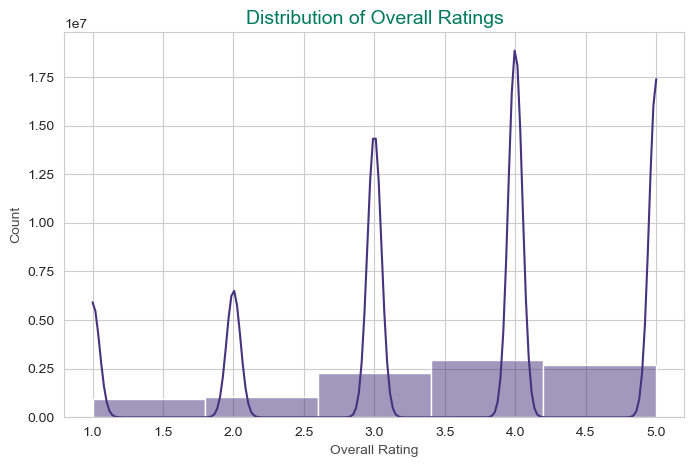

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Glassdoor-styled Seaborn theme
sns.set_style("whitegrid")
sns.set_palette("viridis")  # Green/neutral tones for Glassdoor theme

# Example: Distribution of Overall Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df['overall_rating'], bins=5, kde=True)
plt.title('Distribution of Overall Ratings', fontsize=14, color="#007A5E")  # Green Title
plt.xlabel('Overall Rating', color="#4A4A4A")
plt.ylabel('Count', color="#4A4A4A")
plt.show()


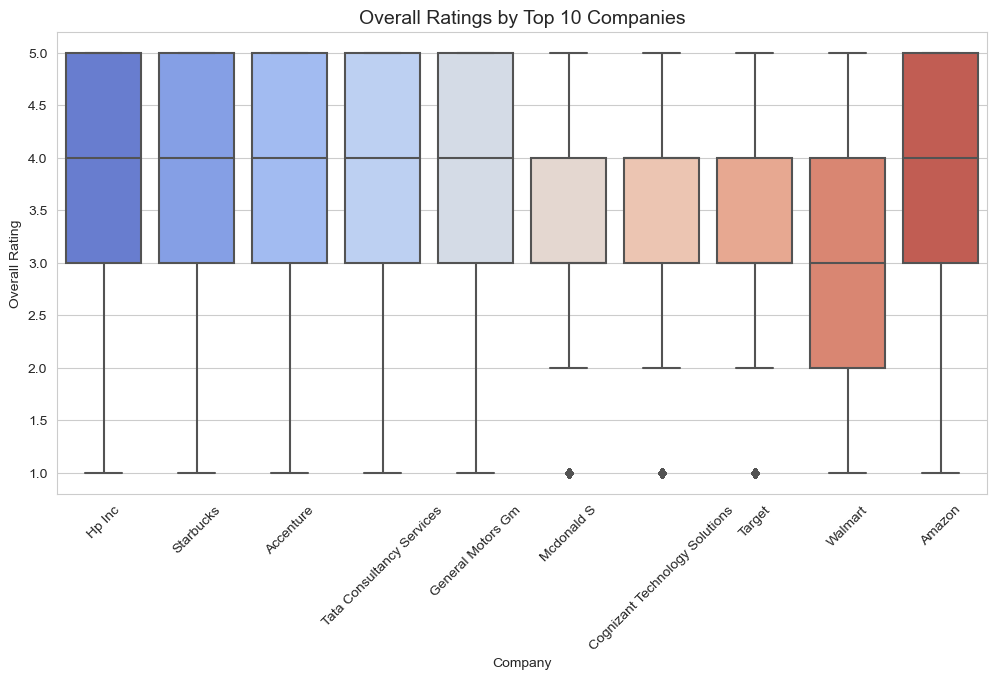

In [58]:
# ✅ 2. Boxplot of Ratings by Company (Top 10)
top_10_companies = df['company'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['company'].isin(top_10_companies)], x='company', y='overall_rating', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Overall Ratings by Top 10 Companies', fontsize=14)
plt.xlabel('Company')
plt.ylabel('Overall Rating')
plt.show()

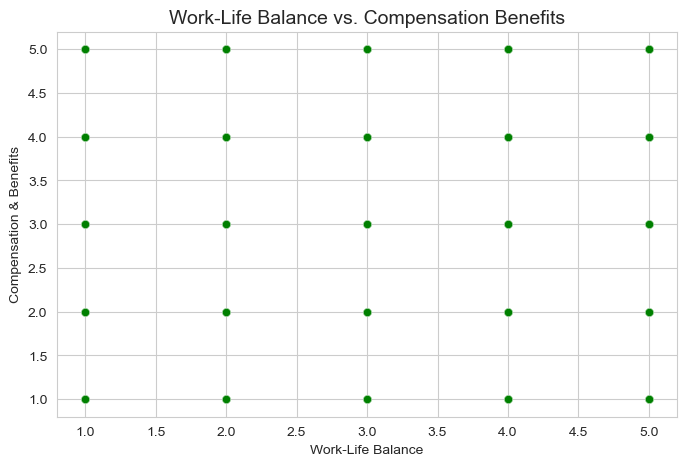

In [59]:
# ✅ 3. Work-Life Balance vs. Compensation Benefits
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='work_life_balance', y='compensation_benefits', alpha=0.3, color='green')
plt.title('Work-Life Balance vs. Compensation Benefits', fontsize=14)
plt.xlabel('Work-Life Balance')
plt.ylabel('Compensation & Benefits')
plt.show()

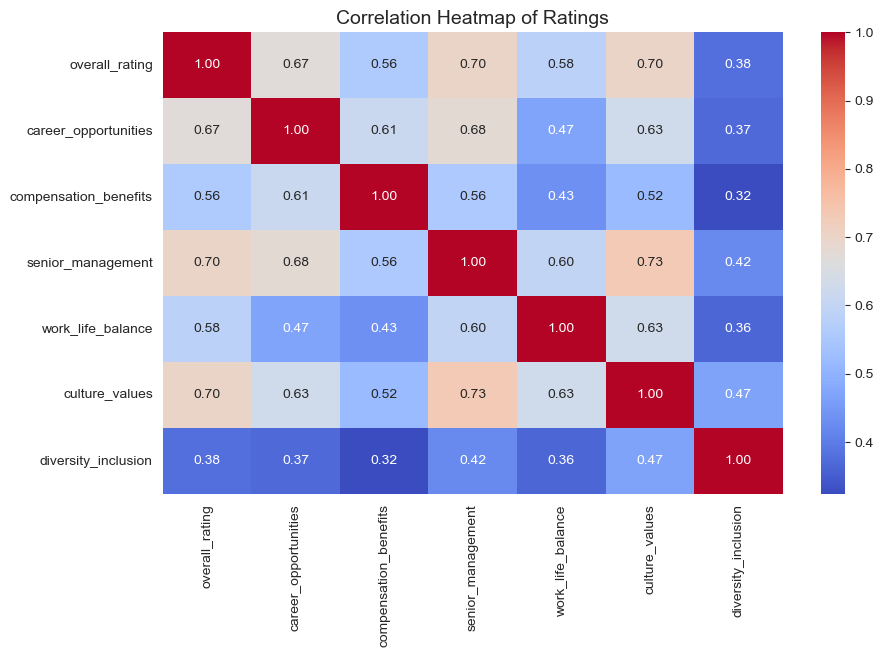

In [60]:
# ✅ 4. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['overall_rating', 'career_opportunities', 'compensation_benefits', 
                'senior_management', 'work_life_balance', 'culture_values', 'diversity_inclusion']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Ratings', fontsize=14)
plt.show()


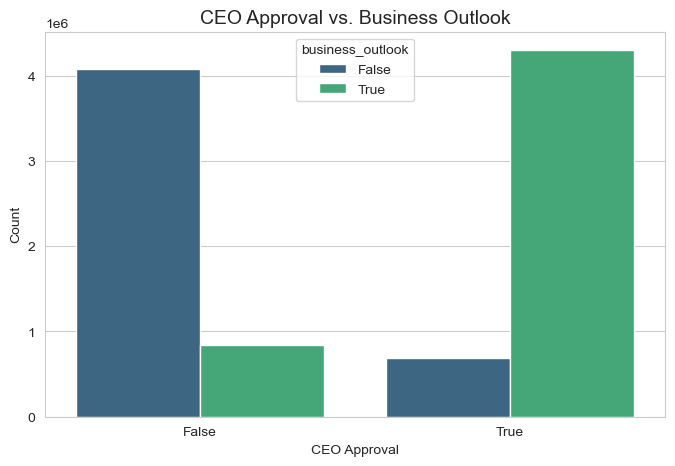

In [61]:
# ✅ 5. CEO Approval vs. Business Outlook (Countplot)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ceo_approval', hue='business_outlook', palette='viridis')
plt.title('CEO Approval vs. Business Outlook', fontsize=14)
plt.xlabel('CEO Approval')
plt.ylabel('Count')
plt.show()

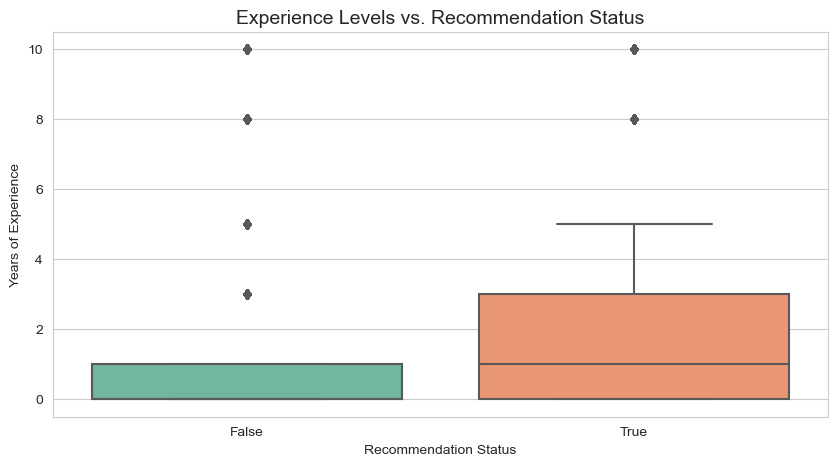

In [62]:
# ✅ 6. Experience Levels vs. Recommendation Status
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='recommendation', y='years_experience', palette='Set2')
plt.title('Experience Levels vs. Recommendation Status', fontsize=14)
plt.xlabel('Recommendation Status')
plt.ylabel('Years of Experience')
plt.show()

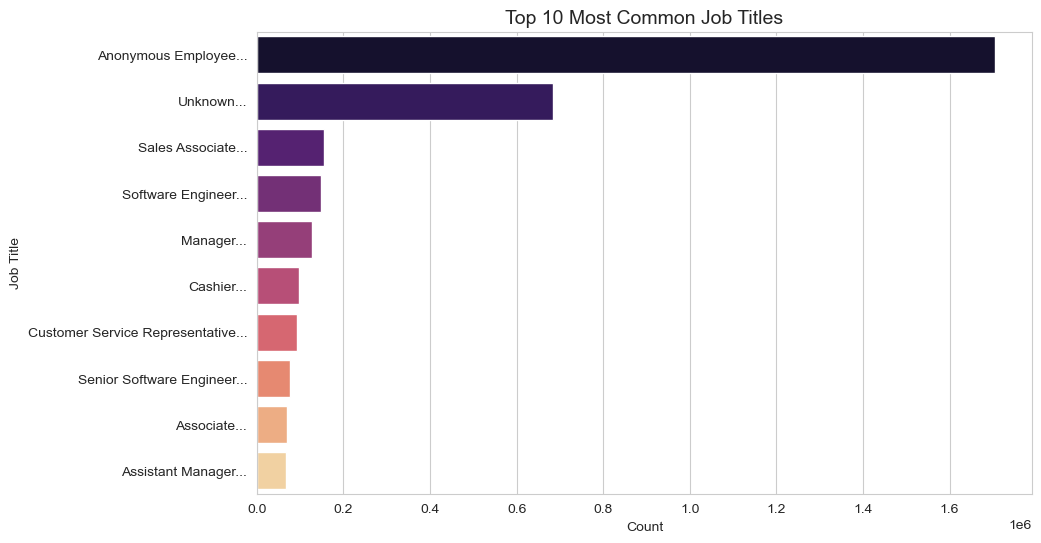

In [63]:
# ✅ 7. Count of Job Titles (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(y=df['job_title'].value_counts().head(10).index, x=df['job_title'].value_counts().head(10), palette='magma')
plt.title('Top 10 Most Common Job Titles', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.show()

In [64]:
from collections import Counter
import re

# Function to clean text and extract most common words
def get_most_common_words(series, num_words=20):
    text = ' '.join(series.dropna().astype(str))  # Combine all text
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words, convert to lowercase
    return Counter(words).most_common(num_words)  # Get most frequent words

# ✅ Most Common Words in Review Titles
common_review_title_words = get_most_common_words(df['review_title'], 20)

# ✅ Most Common Words in Positive Reviews
common_positive_words = get_most_common_words(df['positives'], 20)

# ✅ Most Common Words in Negative Reviews
common_negative_words = get_most_common_words(df['negatives'], 20)

# ✅ Display Results
print("\n🔹 Most Common Words in Review Titles:")
for word, count in common_review_title_words:
    print(f"{word}: {count}")

print("\n🔹 Most Common Words in Positive Reviews:")
for word, count in common_positive_words:
    print(f"{word}: {count}")

print("\n🔹 Most Common Words in Negative Reviews:")
for word, count in common_negative_words:
    print(f"{word}: {count}")



🔹 Most Common Words in Review Titles:
good: 1725637
great: 1561149
to: 1527317
work: 1432069
company: 1235974
place: 965297
a: 729545
for: 710800
and: 606993
the: 523701
job: 453664
not: 427107
of: 354963
but: 323851
experience: 318519
in: 291883
with: 290598
it: 276789
is: 270302
manager: 234069

🔹 Most Common Words in Positive Reviews:
and: 5120445
to: 4205605
good: 3855433
the: 3649111
work: 3279039
great: 2794901
a: 2444755
of: 2182290
is: 1981342
for: 1798474
you: 1646600
with: 1553352
in: 1444546
are: 1435709
benefits: 1422928
people: 1402625
company: 1329695
environment: 1024985
pay: 962081
i: 931651

🔹 Most Common Words in Negative Reviews:
to: 5109206
the: 4945594
and: 4015445
of: 3186400
a: 2988482
is: 2853026
not: 2330503
you: 2131876
in: 2039232
for: 2012184
work: 1875438
no: 1811422
are: 1804157
management: 1451159
be: 1426088
on: 1194060
i: 1179710
with: 1145458
they: 1099330
it: 1036161


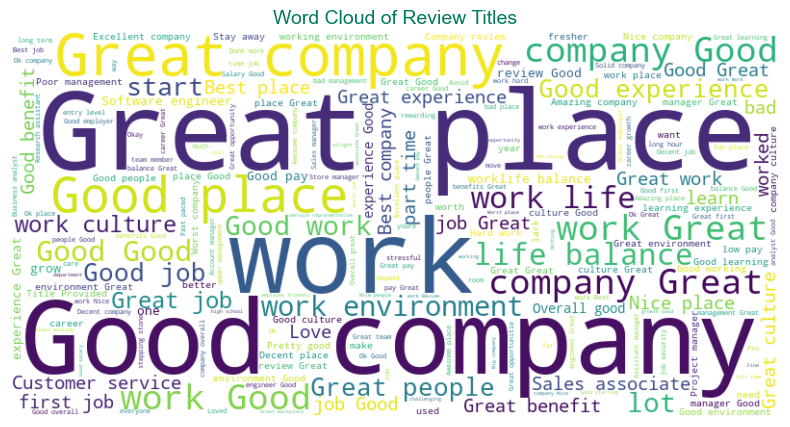

In [65]:


from wordcloud import WordCloud

# Function to generate and display a word cloud
def plot_wordcloud(text_series, title):
    text = ' '.join(text_series.dropna().astype(str))  # Combine all text
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title(title, fontsize=14, color="#007A5E")  # Green title for Glassdoor theme
    plt.show()

#  Word Cloud for Review Titles
plot_wordcloud(df['review_title'], "Word Cloud of Review Titles")




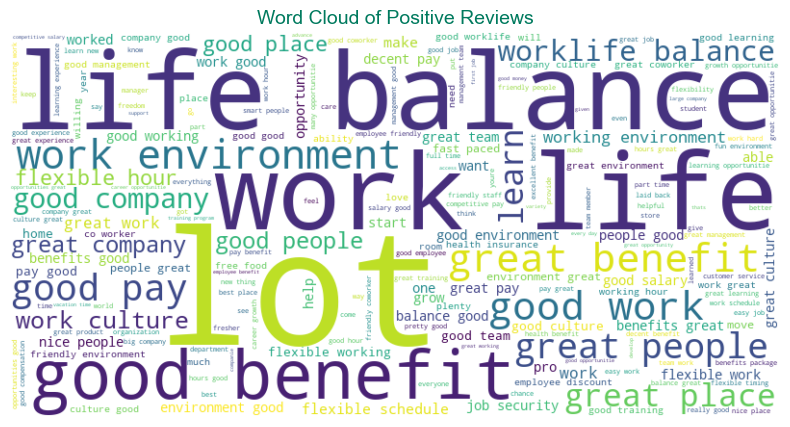

In [67]:

#  Word Cloud for Positive Reviews
plot_wordcloud(df['positives'], "Word Cloud of Positive Reviews")


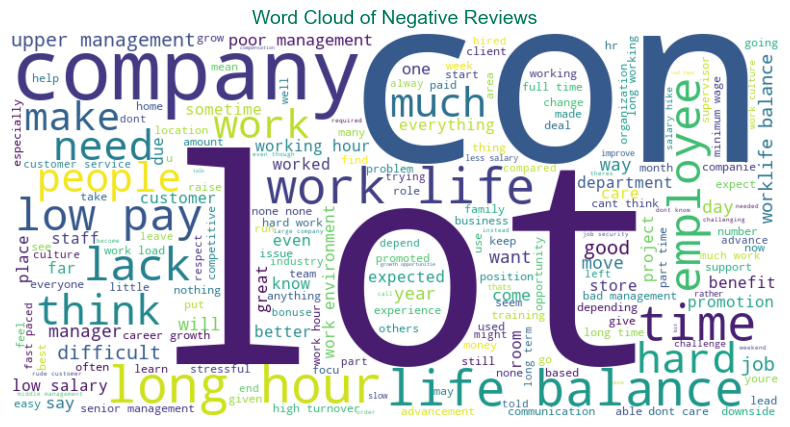

In [68]:
#  Word Cloud for Negative Reviews
plot_wordcloud(df['negatives'], "Word Cloud of Negative Reviews")

In [82]:
# Filter out job titles that are "Anonymous Employee" or "Unknown"
filtered_df = df[~df['job_title'].isin(['Anonymous Employee', 'Unknown'])]

# Get the top 10 most reviewed companies
top_10_companies = filtered_df['company'].value_counts().head(10).index

# Filter dataset to only include reviews from the top 10 companies
top_companies_df = filtered_df[filtered_df['company'].isin(top_10_companies)]

# Get the most common job titles for each top company
most_common_roles = (
    top_companies_df.groupby('company')['job_title']
    .apply(lambda x: x.value_counts().head(5))  # Get top 5 most common roles per company
)

# Convert to DataFrame for readability
most_common_roles_df = most_common_roles.reset_index().rename(columns={'level_1': 'job_title', 'job_title': 'count'})




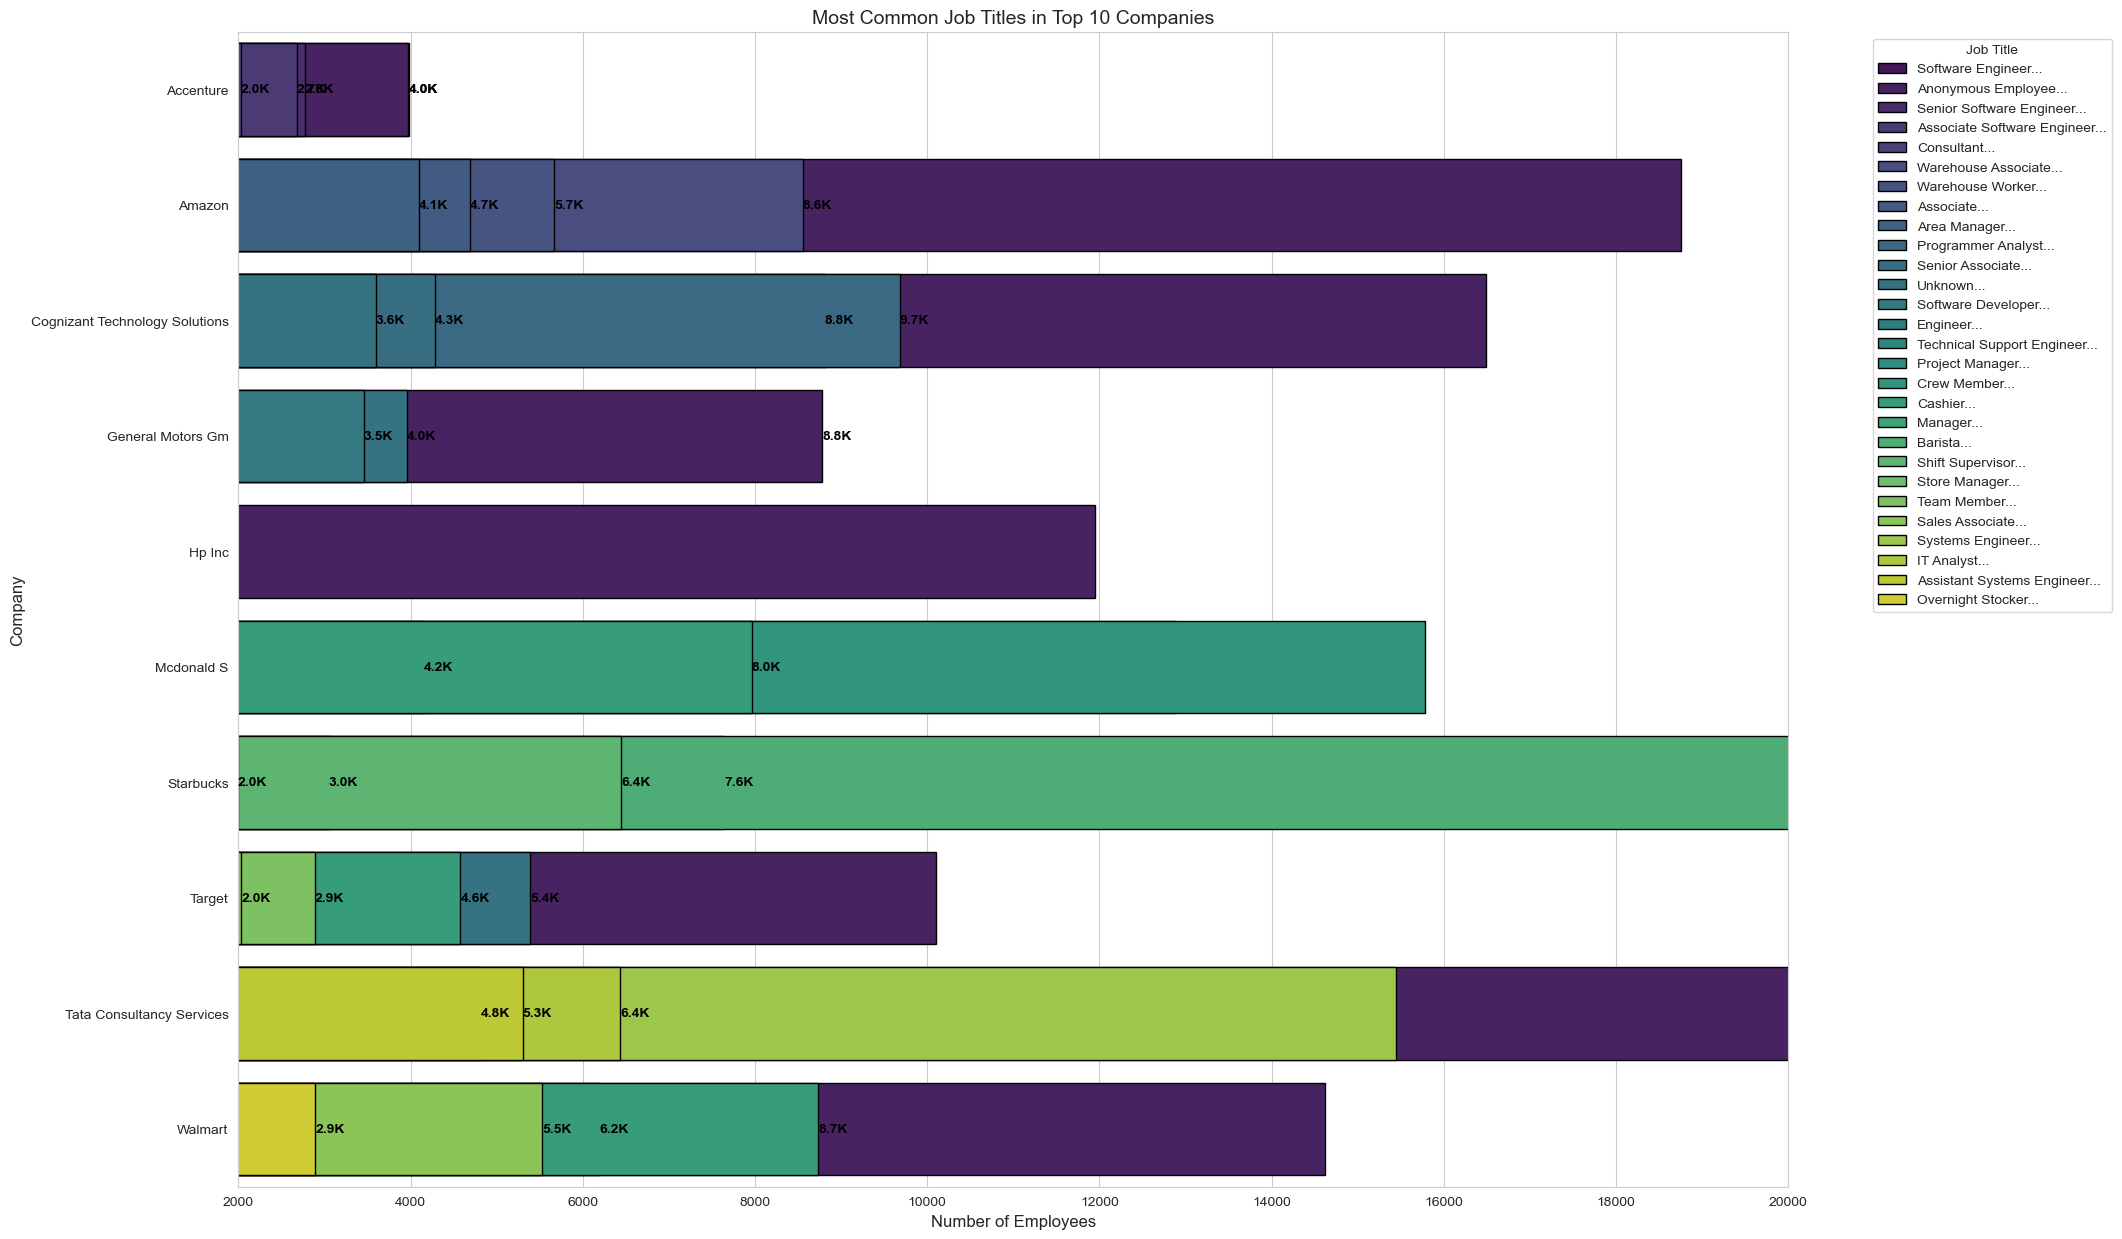

In [97]:
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")
# ✅ Create a Horizontal Bar Plot
plt.figure(figsize=(20, 15))
ax = sns.barplot(data=most_common_roles_df, x='count', y='company', hue='job_title', palette='viridis',dodge=False, width=0.8, edgecolor="black")

# ✅ Set X-Axis Range (1000 to 10000) with Intervals of 1000
plt.xlim(2000, 20000)
plt.xticks(range(2000, 20001, 2000))

# ✅ Add Data Labels in Short Form (e.g., 5K, 10K)
for p in ax.patches:
    width = p.get_width()
    if 1000 <= width <= 10000:  # Only label within range
        ax.annotate(f'{width/1000:.1f}K', (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=10, color='black', weight='bold')

# ✅ Improve Readability
plt.title('Most Common Job Titles in Top 10 Companies', fontsize=14)
plt.xlabel('Number of Employees', fontsize=12)
plt.ylabel('Company', fontsize=12)
plt.legend(title="Job Title", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Sending the data into SQL using SQLAlchemy

In [98]:

import mysql.connector

host = "10.48.123.89" 
port = 3307
user = "root"
password = "lokesh0204@B"
database = "glassdoor_db"

try:
    conn = mysql.connector.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=database
    )
    cursor = conn.cursor()
    cursor.execute("SHOW TABLES;")
    tables = cursor.fetchall()
    print("Connected to MySQL! Tables in database:", tables)
except mysql.connector.Error as err:
    print(f"❌ Connection failed: {err}")


Connected to MySQL! Tables in database: [('glassdoor_reviews',)]


In [99]:
cursor.execute("SELECT COUNT(*) FROM glassdoor_reviews;")
record_count = cursor.fetchone()[0]
print(f"Total records in glassdoor_reviews: {record_count}")

cursor.execute("SELECT * FROM glassdoor_reviews LIMIT 5;")
sample_rows = cursor.fetchall()
for row in sample_rows:
    print(row)


Total records in glassdoor_reviews: 9901638
(1, datetime.datetime(2022, 11, 19, 0, 0), 'Baja Steel And Fence', 'Manager Design...', 'Current Employee', 10.0, 'Good', 5.0, 'knowledge gain of complete project', 'financial growth and personal growth', 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, '1', '0', '1')
(2, datetime.datetime(2022, 1, 29, 0, 0), 'Baja Steel And Fence', 'Anonymous Employee...', 'Former Employee', 1.0, 'Good', 4.0, 'good work,good work , flexible, support', 'good,work, flexible,good support, good team work', 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, '1', '0', '0')
(3, datetime.datetime(2021, 8, 12, 0, 0), 'Baja Steel And Fence', 'Production Engineer...', 'Current Employee', 1.0, 'Supervising the manufacturing the processes, ensuring quality work is done in a safe efficient manne', 4.0, 'this company is a best opportunity for me to learnings core mechanical field.', 'monthly target work,maintain production scheduled, evaluate production efficiency.', 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, '1', '0', '1')


In [118]:
import sqlalchemy
import pandas as pd

print("SQLAlchemy and Pandas are installed correctly!")


SQLAlchemy and Pandas are installed correctly!


In [122]:
data_tuples = df.to_records(index=False).tolist()  

In [123]:
# # Reconnect to MySQL
# conn = mysql.connector.connect(
#     host="10.48.122.213",
#     port=3307,
#     user="root",
#     password="lokesh0204@B",
#    database="glassdoor_db"
# )
cursor = conn.cursor()

# Define batch size
batch_size = 10000  

# Generate INSERT SQL query
columns = ",".join([f"`{col}`" for col in df.columns]) 
values_placeholder = ",".join(["%s"] * len(df.columns))
sql_query = f"INSERT INTO glassdoor_reviews ({columns}) VALUES ({values_placeholder})"

# Insert data in batches
for i in range(0, len(data_tuples), batch_size):
    batch = data_tuples[i:i + batch_size]
    cursor.executemany(sql_query, batch)
    conn.commit()
    print(f" Inserted {i + batch_size} rows successfully...")


print(" Upload Completed!")


 Inserted 10000 rows successfully...
 Inserted 20000 rows successfully...
 Inserted 30000 rows successfully...
 Inserted 40000 rows successfully...
 Inserted 50000 rows successfully...
 Inserted 60000 rows successfully...
 Inserted 70000 rows successfully...
 Inserted 80000 rows successfully...
 Inserted 90000 rows successfully...
 Inserted 100000 rows successfully...
 Inserted 110000 rows successfully...
 Inserted 120000 rows successfully...
 Inserted 130000 rows successfully...
 Inserted 140000 rows successfully...
 Inserted 150000 rows successfully...
 Inserted 160000 rows successfully...
 Inserted 170000 rows successfully...
 Inserted 180000 rows successfully...
 Inserted 190000 rows successfully...
 Inserted 200000 rows successfully...
 Inserted 210000 rows successfully...
 Inserted 220000 rows successfully...
 Inserted 230000 rows successfully...
 Inserted 240000 rows successfully...
 Inserted 250000 rows successfully...
 Inserted 260000 rows successfully...
 Inserted 270000 rows

 Inserted 2140000 rows successfully...
 Inserted 2150000 rows successfully...
 Inserted 2160000 rows successfully...
 Inserted 2170000 rows successfully...
 Inserted 2180000 rows successfully...
 Inserted 2190000 rows successfully...
 Inserted 2200000 rows successfully...
 Inserted 2210000 rows successfully...
 Inserted 2220000 rows successfully...
 Inserted 2230000 rows successfully...
 Inserted 2240000 rows successfully...
 Inserted 2250000 rows successfully...
 Inserted 2260000 rows successfully...
 Inserted 2270000 rows successfully...
 Inserted 2280000 rows successfully...
 Inserted 2290000 rows successfully...
 Inserted 2300000 rows successfully...
 Inserted 2310000 rows successfully...
 Inserted 2320000 rows successfully...
 Inserted 2330000 rows successfully...
 Inserted 2340000 rows successfully...
 Inserted 2350000 rows successfully...
 Inserted 2360000 rows successfully...
 Inserted 2370000 rows successfully...
 Inserted 2380000 rows successfully...
 Inserted 2390000 rows su

 Inserted 4250000 rows successfully...
 Inserted 4260000 rows successfully...
 Inserted 4270000 rows successfully...
 Inserted 4280000 rows successfully...
 Inserted 4290000 rows successfully...
 Inserted 4300000 rows successfully...
 Inserted 4310000 rows successfully...
 Inserted 4320000 rows successfully...
 Inserted 4330000 rows successfully...
 Inserted 4340000 rows successfully...
 Inserted 4350000 rows successfully...
 Inserted 4360000 rows successfully...
 Inserted 4370000 rows successfully...
 Inserted 4380000 rows successfully...
 Inserted 4390000 rows successfully...
 Inserted 4400000 rows successfully...
 Inserted 4410000 rows successfully...
 Inserted 4420000 rows successfully...
 Inserted 4430000 rows successfully...
 Inserted 4440000 rows successfully...
 Inserted 4450000 rows successfully...
 Inserted 4460000 rows successfully...
 Inserted 4470000 rows successfully...
 Inserted 4480000 rows successfully...
 Inserted 4490000 rows successfully...
 Inserted 4500000 rows su

 Inserted 6360000 rows successfully...
 Inserted 6370000 rows successfully...
 Inserted 6380000 rows successfully...
 Inserted 6390000 rows successfully...
 Inserted 6400000 rows successfully...
 Inserted 6410000 rows successfully...
 Inserted 6420000 rows successfully...
 Inserted 6430000 rows successfully...
 Inserted 6440000 rows successfully...
 Inserted 6450000 rows successfully...
 Inserted 6460000 rows successfully...
 Inserted 6470000 rows successfully...
 Inserted 6480000 rows successfully...
 Inserted 6490000 rows successfully...
 Inserted 6500000 rows successfully...
 Inserted 6510000 rows successfully...
 Inserted 6520000 rows successfully...
 Inserted 6530000 rows successfully...
 Inserted 6540000 rows successfully...
 Inserted 6550000 rows successfully...
 Inserted 6560000 rows successfully...
 Inserted 6570000 rows successfully...
 Inserted 6580000 rows successfully...
 Inserted 6590000 rows successfully...
 Inserted 6600000 rows successfully...
 Inserted 6610000 rows su

 Inserted 8470000 rows successfully...
 Inserted 8480000 rows successfully...
 Inserted 8490000 rows successfully...
 Inserted 8500000 rows successfully...
 Inserted 8510000 rows successfully...
 Inserted 8520000 rows successfully...
 Inserted 8530000 rows successfully...
 Inserted 8540000 rows successfully...
 Inserted 8550000 rows successfully...
 Inserted 8560000 rows successfully...
 Inserted 8570000 rows successfully...
 Inserted 8580000 rows successfully...
 Inserted 8590000 rows successfully...
 Inserted 8600000 rows successfully...
 Inserted 8610000 rows successfully...
 Inserted 8620000 rows successfully...
 Inserted 8630000 rows successfully...
 Inserted 8640000 rows successfully...
 Inserted 8650000 rows successfully...
 Inserted 8660000 rows successfully...
 Inserted 8670000 rows successfully...
 Inserted 8680000 rows successfully...
 Inserted 8690000 rows successfully...
 Inserted 8700000 rows successfully...
 Inserted 8710000 rows successfully...
 Inserted 8720000 rows su

In [100]:
cursor = conn.cursor()

# Function to run SQL queries and return results as a DataFrame
def run_query(query):
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Extract column names
    return pd.DataFrame(data, columns=columns)  # Convert to DataFrame

# Example Query: Get total record count
query = "SELECT COUNT(*) AS total_records FROM glassdoor_reviews;"
df_result = run_query(query)

# Display the result
print(df_result)

   total_records
0        9901638


In [121]:
# Work-Life Balance Scores Across Companies
query = "SELECT company, AVG(work_life_balance) AS avg_work_life_balance FROM glassdoor_reviews GROUP BY company ORDER BY avg_work_life_balance DESC LIMIT 10;"
df_result = run_query(query)

# Display the result
print(df_result)

                        company  avg_work_life_balance
0                      1Leisure                    5.0
1        360 Resource Solutions                    5.0
2        2X Tecnologia Em Dobro                    5.0
3            3Monkeyproductions                    5.0
4                  3 Point Teks                    5.0
5  7 Arts Construction & Design                    5.0
6               12 Hour Massage                    5.0
7                  21 Comunicao                    5.0
8                    5K Network                    5.0
9              1 Stop Esolution                    5.0


In [122]:
# Most Common Job Titles
query = """SELECT job_title, COUNT(*) AS total_reviews
FROM glassdoor_reviews
GROUP BY job_title
ORDER BY total_reviews DESC
LIMIT 10;
"""
df_result = run_query(query)

# Display the result
print(df_result)

                            job_title  total_reviews
0               Anonymous Employee...        1704837
1                          Unknown...         682953
2                  Sales Associate...         155608
3                Software Engineer...         147930
4                          Manager...         127822
5                          Cashier...          96669
6  Customer Service Representative...          92008
7         Senior Software Engineer...          76179
8                        Associate...          68667
9                Assistant Manager...          68193


In [123]:
# Close connection
cursor.close()
conn.close()